In [1]:
print ("hello world")

hello world


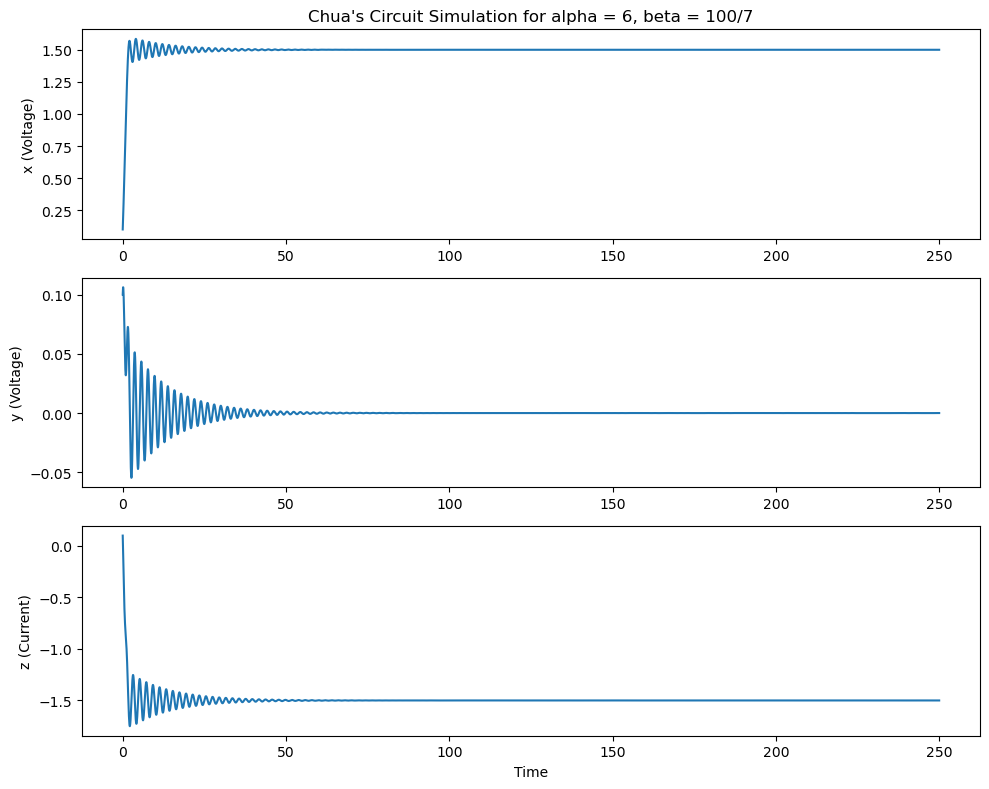

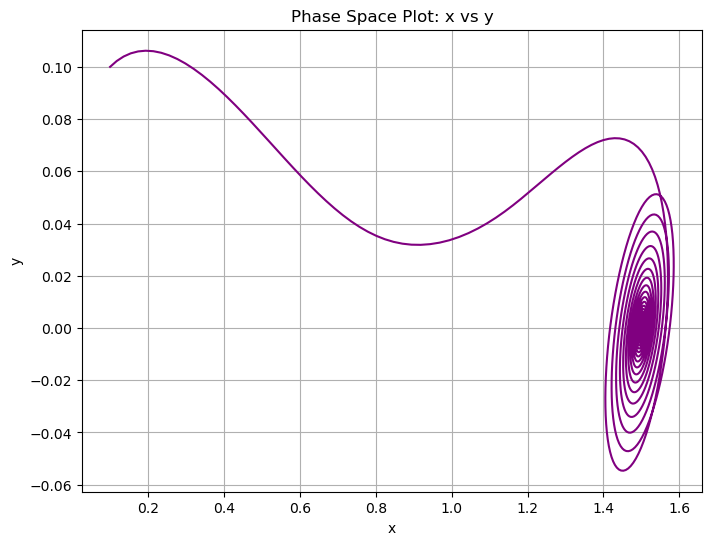

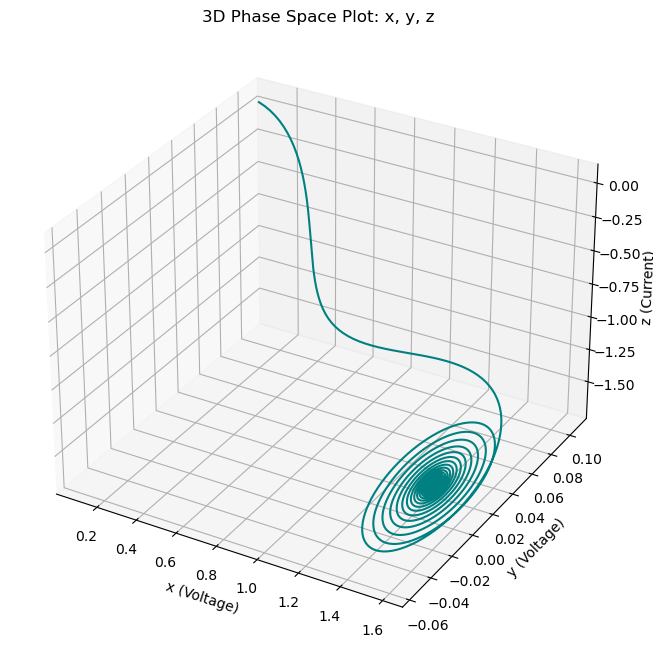

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D

# Parameters for Chua's Circuit
alpha = 6.0               # Parameter related to capacitances and resistances
beta = 100 / 7            # Parameter related to inductance and resistance
m0 = -1.143               # Slope of the first region in Chua's diode (nonlinear resistor)
m1 = -0.714               # Slope of the second region in Chua's diode (nonlinear resistor)

# Define the nonlinear function for Chua's diode
def chua_diode(x):
    return m1 * x + 0.5 * (m0 - m1) * (abs(x + 1) - abs(x - 1))

# Differential equations for Chua's Circuit
def chua_circuit(t, state):
    x, y, z = state
    dxdt = alpha * (y - x - chua_diode(x))
    dydt = x - y + z
    dzdt = -beta * y
    return [dxdt, dydt, dzdt]

# Initial conditions and time span
initial_state = [0.1, 0.1, 0.1]              # Starting values for x, y, z
t_span = (0, 250)                            # Time interval
t_eval = np.linspace(0, 250, 10000)          # Time points to evaluate

# Solve the differential equations
solution = solve_ivp(chua_circuit, t_span, initial_state, t_eval=t_eval, method='RK45')

# Plotting the results (x, y, z vs time)
fig, axs = plt.subplots(3, 1, figsize=(10, 8))

# Plot x vs t
axs[0].plot(solution.t, solution.y[0])
axs[0].set_title("Chua's Circuit Simulation for alpha = 6, beta = 100/7")
axs[0].set_ylabel('x (Voltage)')

# Plot y vs t
axs[1].plot(solution.t, solution.y[1])
axs[1].set_ylabel('y (Voltage)')

# Plot z vs t
axs[2].plot(solution.t, solution.y[2])
axs[2].set_ylabel('z (Current)')
axs[2].set_xlabel('Time')

plt.tight_layout()
plt.show()

# Phase space plot (x vs y)
plt.figure(figsize=(8, 6))
plt.plot(solution.y[0], solution.y[1], color='purple')
plt.title("Phase Space Plot: x vs y")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

# 3D Phase Space Plot (x vs y vs z)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting x, y, z in 3D space
ax.plot(solution.y[0], solution.y[1], solution.y[2], color='teal', lw=1.5)

# Setting labels and title
ax.set_title("3D Phase Space Plot: x, y, z")
ax.set_xlabel("x (Voltage)")
ax.set_ylabel("y (Voltage)")
ax.set_zlabel("z (Current)")

# Display the plot
plt.show()
